In [92]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

regression_example_train = pd.read_csv('RegressionExample_train.csv')
regression_example_test_X = pd.read_csv('RegressionExample_test_input.csv')
regression_example_test_y = pd.read_csv('RegressionExample_test_output.csv')

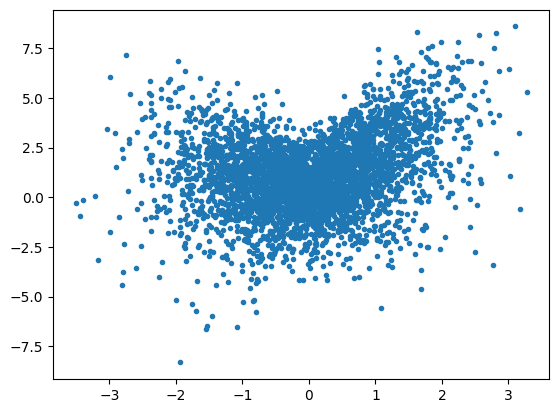

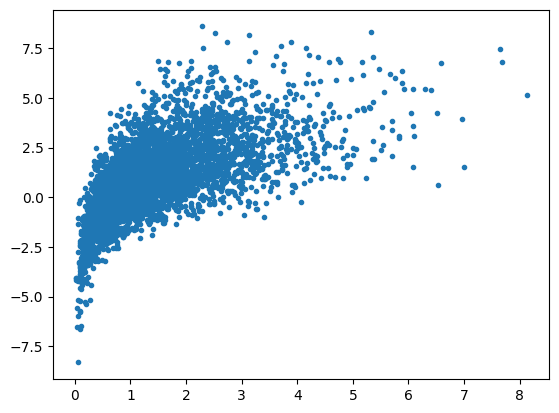

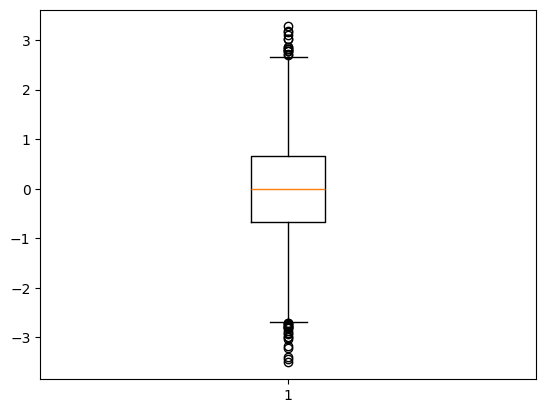

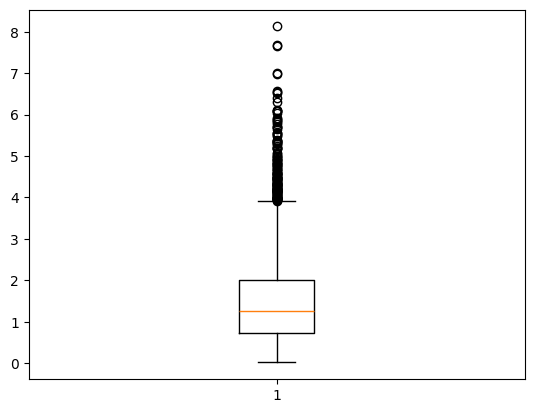

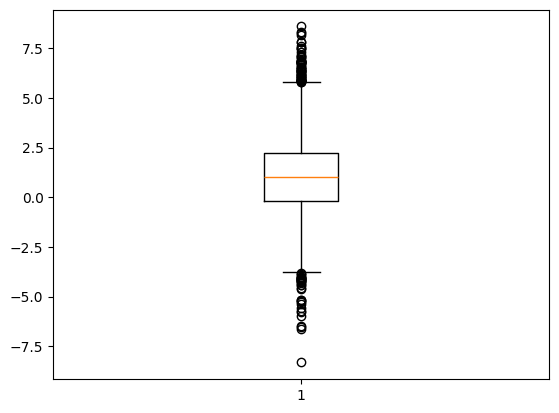

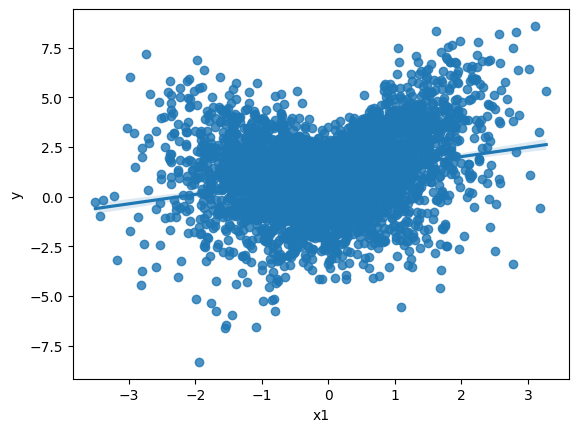

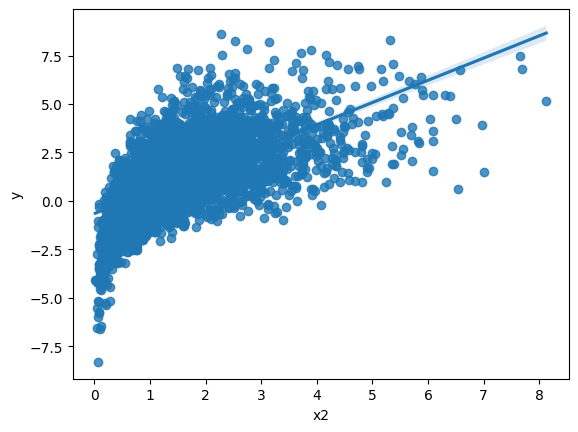

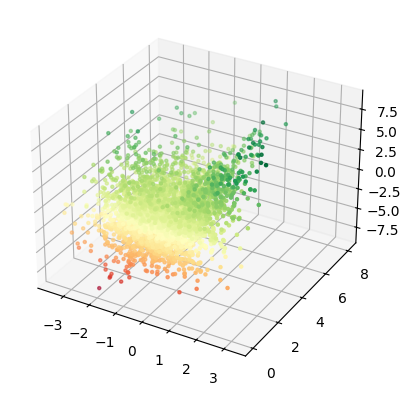

In [97]:
# print(regression_example_train.isna())  # no NaNs in evidence

plt.scatter(regression_example_train[['x1']], regression_example_train[['y']], marker='.')
plt.show()
plt.scatter(regression_example_train[['x2']], regression_example_train[['y']], marker='.')
plt.show()

# plt.scatter(regression_example_train[['x1']], regression_example_train[['x2']], marker='.')
# plt.show()  # x1 is distributed with mean 0; x2 is always positive

plt.boxplot(regression_example_train[['x1']])
plt.show()
plt.boxplot(regression_example_train[['x2']])
plt.show()
plt.boxplot(regression_example_train[['y']])
plt.show()

ols1 = LinearRegression()
ols1.fit(regression_example_train[['x1']], regression_example_train[['y']])
sns.regplot(data=regression_example_train, x = 'x1', y = 'y')
plt.show()  # y is not monotonic in x1

ols2 = LinearRegression()
ols2.fit(regression_example_train[['x2']], regression_example_train[['y']])
sns.regplot(data=regression_example_train, x = 'x2', y = 'y')
plt.show()  # way too heteroskedastic!

# mls = LinearRegression()
# mls.fit(regression_example_train[['x1', 'x2']], regression_example_train[['y']])  # a hypothesis: what if y is a linear combination of X_i (plus maybe an error term?)
# print(mls.coef_, mls.intercept_)

# fig = plt.figure()
cm = plt.get_cmap("RdYlGn")
ax = plt.axes(projection='3d')
# ax.view_init(30, 60)  # change to suit
ax.scatter(regression_example_train[['x1']], regression_example_train[['x2']], regression_example_train[['y']], c=regression_example_train[['y']], marker='.', cmap=cm)
# Increasing x1 seems to decrease the strength of the predictive power of x2 on y... maybe I need an interaction model?

          y        x1        x2        xp     x1abs      x1sq     x2log  \
0  2.580808 -1.655870  1.243678 -2.059370  1.655870  2.741906  0.218073   
1  2.085190  0.882247  1.299029  1.146064  0.882247  0.778359  0.261617   
2  0.016945 -0.341965  3.650802 -1.248445  0.341965  0.116940  1.294947   
3  0.689864 -1.469734  1.370667 -2.014516  1.469734  2.160119  0.315297   
4 -0.825232  0.323903  0.534371  0.173084  0.323903  0.104913 -0.626665   

        x2sq  
0   1.546736  
1   1.687477  
2  13.328356  
3   1.878727  
4   0.285552  


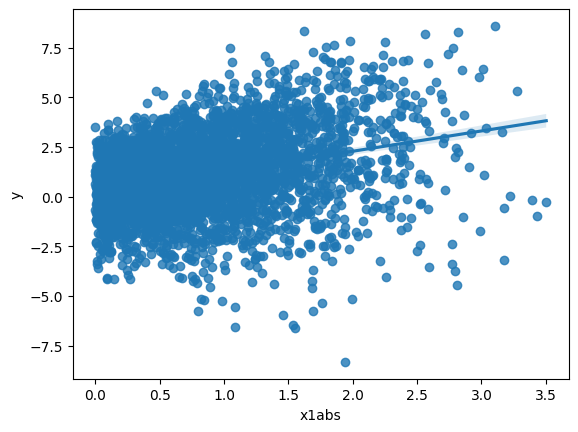

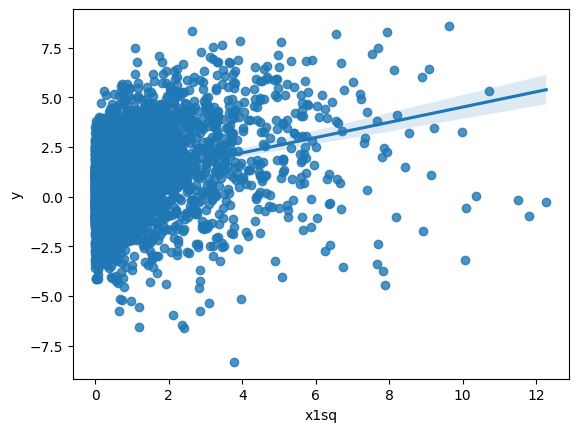

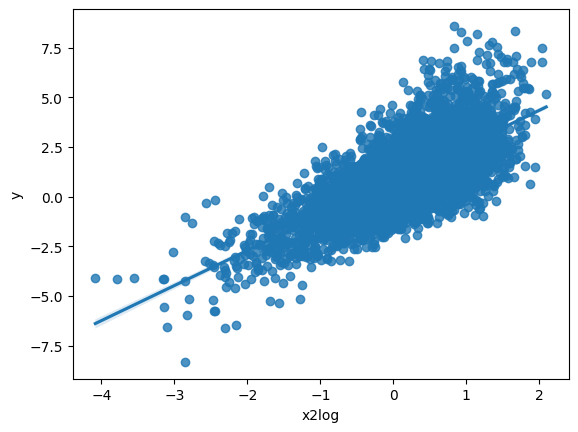

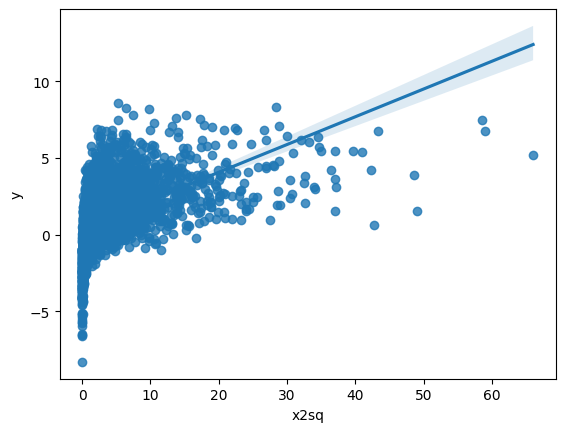

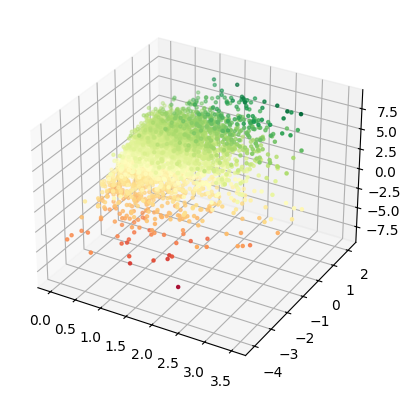

In [94]:
regression_example_train['xp'] = regression_example_train['x1'] * regression_example_train['x2']
regression_example_train['x1abs'] = np.abs(regression_example_train['x1']) # y seems to increase with increasing |x1|
regression_example_train['x1sq'] = regression_example_train['x1'] ** 2 # y seems to increase with increasing |x1|
regression_example_train['x2log'] = np.log(regression_example_train['x2'])  # x2 is never nonpositive and y increases nonlinearly with increasing x2
regression_example_train['x2sq'] = regression_example_train['x2'] ** 2
print(regression_example_train.head())

sns.regplot(data=regression_example_train, x = 'x1abs', y = 'y')  # way more linear! we can see the huge noise better now.
plt.show()
sns.regplot(data=regression_example_train, x = 'x1sq', y = 'y')  # way more linear! we can see the huge noise better now.
plt.show()

sns.regplot(data=regression_example_train, x = 'x2log', y = 'y')
plt.show()
sns.regplot(data=regression_example_train, x = 'x2sq', y = 'y')  # sq is much worse than log
plt.show()

cm = plt.get_cmap("RdYlGn")
ax = plt.axes(projection='3d')
# ax.view_init(30, 75)  # change to suit
ax.scatter(regression_example_train[['x1abs']], regression_example_train[['x2log']], regression_example_train[['y']], c=regression_example_train[['y']], marker='.', cmap=cm)
plt.show()

In [95]:
num_splits = 5
num_models = 11
kfold = KFold(num_splits,
              random_state = 518,
              shuffle=True)

## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(regression_example_train):
    ## cv training set
    regression_example_tt = regression_example_train.iloc[train_index]
    
    ## cv holdout set
    regression_example_ho = regression_example_train.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = regression_example_tt.y.mean()*np.ones(len(regression_example_ho))
    rmses[0, i] = root_mean_squared_error(regression_example_ho.y, baseline_pred)
    
    ## Fit and get ho mse for slr model
    slr1 = LinearRegression()
    slr1.fit(regression_example_tt[['x1']], regression_example_tt.y)
    rmses[1, i] = root_mean_squared_error(regression_example_ho.y, slr1.predict(regression_example_ho[['x1']]))

    slr2 = LinearRegression()
    slr2.fit(regression_example_tt[['x2']], regression_example_tt.y)
    rmses[2, i] = root_mean_squared_error(regression_example_ho.y, slr2.predict(regression_example_ho[['x2']]))
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    mlr.fit(regression_example_tt[['x1', 'x2']], regression_example_tt.y)
    rmses[3, i] = root_mean_squared_error(regression_example_ho.y, mlr.predict(regression_example_ho[['x1', 'x2']]))
    
    # May as well throw some nonparametric at the wall here too
    knn = KNeighborsRegressor()
    knn.fit(regression_example_tt[['x1', 'x2']], regression_example_tt.y)
    rmses[4, i] = root_mean_squared_error(regression_example_ho.y, knn.predict(regression_example_ho[['x1', 'x2']]))

    # May as well throw interaction terms at the wall here too
    intlr = LinearRegression()
    intlr.fit(regression_example_tt[['x1', 'x2', 'xp']], regression_example_tt.y)
    rmses[5, i] = root_mean_squared_error(regression_example_ho.y, intlr.predict(regression_example_ho[['x1', 'x2', 'xp']]))

    ## Linear regressions on nonlinear transformations suggested by the visualizations
    xflr1 = LinearRegression()
    xflr1.fit(regression_example_tt[['x1abs']], regression_example_tt.y)
    rmses[6, i] = root_mean_squared_error(regression_example_ho.y, xflr1.predict(regression_example_ho[['x1abs']]))

    xflr1s = LinearRegression()
    xflr1s.fit(regression_example_tt[['x1sq']], regression_example_tt.y)
    rmses[7, i] = root_mean_squared_error(regression_example_ho.y, xflr1s.predict(regression_example_ho[['x1sq']]))

    xflr2 = LinearRegression()
    xflr2.fit(regression_example_tt[['x2log']], regression_example_tt.y)
    rmses[8, i] = root_mean_squared_error(regression_example_ho.y, xflr2.predict(regression_example_ho[['x2log']]))

    xfmlr = LinearRegression()
    xfmlr.fit(regression_example_tt[['x1abs', 'x2log']], regression_example_tt.y)
    rmses[9, i] = root_mean_squared_error(regression_example_ho.y, xfmlr.predict(regression_example_ho[['x1abs', 'x2log']]))

    xfmlrs = LinearRegression()
    xfmlrs.fit(regression_example_tt[['x1sq', 'x2log']], regression_example_tt.y)
    rmses[10, i] = root_mean_squared_error(regression_example_ho.y, xfmlrs.predict(regression_example_ho[['x1sq', 'x2log']]))

    i = i + 1

models = [slr1, slr2, mlr, knn, intlr, xflr1, xflr2, xfmlr]

print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"SLR1 Avg. CV MSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"SLR2 Avg. CV MSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"MLR Avg. CV MSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"kNN Avg. CV MSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")
print(f"MLRx Avg. CV MSE: {np.mean(rmses[5,:])} and STD: {np.std(rmses[5,:])}")
print(f"TF SLR1 Avg. CV MSE: {np.mean(rmses[6,:])} and STD: {np.std(rmses[6,:])}")
print(f"TF SLR1s Avg. CV MSE: {np.mean(rmses[7,:])} and STD: {np.std(rmses[7,:])}")
print(f"TF SLR2 Avg. CV MSE: {np.mean(rmses[8,:])} and STD: {np.std(rmses[8,:])}")
print(f"TF MLR Avg. CV MSE: {np.mean(rmses[9,:])} and STD: {np.std(rmses[9,:])}")
print(f"TF MLRs Avg. CV MSE: {np.mean(rmses[10,:])} and STD: {np.std(rmses[10,:])}")

# Baseline Avg. CV RMSE: 1.9596968599417361 and STD: 0.02810502683853512
# SLR1 Avg. CV MSE: 1.9005547986104951 and STD: 0.026777927604459528
# SLR2 Avg. CV MSE: 1.5254627124769322 and STD: 0.03596065366654463
# MLR Avg. CV MSE: 1.446452967111766 and STD: 0.04530980413837644
# kNN Avg. CV MSE: 1.1194911928881834 and STD: 0.023715534361380356
# MLRx Avg. CV MSE: 1.4465989584139307 and STD: 0.04527074794015183
# TF SLR1 Avg. CV MSE: 1.8568161531661125 and STD: 0.02254561625978875
# TF SLR2 Avg. CV MSE: 1.370751352624993 and STD: 0.022422007361562746
# TF MLR Avg. CV MSE: 1.2159593613737183 and STD: 0.011495620281349211

# Baseline sucks and pure x1 isn't much better
# Pure x2 is OK as is MLR on both x1 and x2; adding the 2nd-degree interaction term isn't much help.
# Transforming x1 to |x1| doesn't help all that much, but transforming x1 to x1^2 helps even less.
# But transforming x2 to log(x2) helps quite a lot
# And the doubly-transformed MLR over |x1| and log(x2) is the best parametric model of all

bestpmodel = xfmlr

print(bestpmodel.coef_, bestpmodel.intercept_)
# [1.01302726 1.77572556] 0.002395294019301497
# y ~ 1.01 |x1| + 1.78 log(x2)

Baseline Avg. CV RMSE: 1.9596968599417361 and STD: 0.02810502683853512
SLR1 Avg. CV MSE: 1.9005547986104951 and STD: 0.026777927604459528
SLR2 Avg. CV MSE: 1.5254627124769322 and STD: 0.03596065366654463
MLR Avg. CV MSE: 1.446452967111766 and STD: 0.04530980413837644
kNN Avg. CV MSE: 1.1194911928881834 and STD: 0.023715534361380356
MLRx Avg. CV MSE: 1.4465989584139307 and STD: 0.04527074794015183
TF SLR1 Avg. CV MSE: 1.8568161531661125 and STD: 0.02254561625978875
TF SLR1s Avg. CV MSE: 1.8794094684028355 and STD: 0.03018459748569513
TF SLR2 Avg. CV MSE: 1.370751352624993 and STD: 0.022422007361562746
TF MLR Avg. CV MSE: 1.2159593613737183 and STD: 0.011495620281349211
TF MLRs Avg. CV MSE: 1.2455877710992973 and STD: 0.02235157108259824
[1.01302726 1.77572556] 0.002395294019301497


         x1        x2     x1abs     x2log
0 -0.054425  0.738897  0.054425 -0.302597
1 -0.623979  0.420441  0.623979 -0.866451
2 -0.542209  1.321597  0.542209  0.278841
3  1.283086  5.854481  1.283086  1.767207
4 -1.902312  1.382814  1.902312  0.324121
[[1.12037498 1.85497808]] [-0.14156016]
1.263710307000043


C:\Users\Lorxus\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


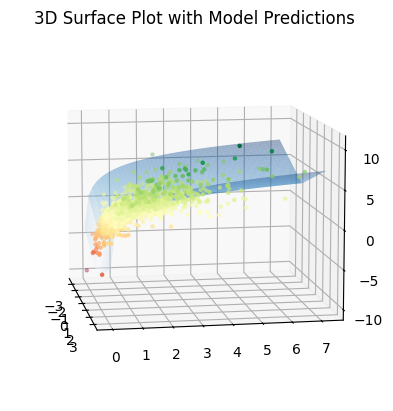

In [96]:
regression_example_test_X['x1abs'] = np.abs(regression_example_test_X['x1'])
regression_example_test_X['x2log'] = np.log(regression_example_test_X['x2'])
print(regression_example_test_X.head())

bestpmodel.fit(regression_example_test_X[['x1abs', 'x2log']], regression_example_test_y)
modelrms = root_mean_squared_error(regression_example_test_y, xfmlr.predict(regression_example_test_X[['x1abs', 'x2log']]))
print(bestpmodel.coef_, bestpmodel.intercept_)
print(modelrms)

from matplotlib import cm as colormap
from scipy.interpolate import griddata

# cm = plt.get_cmap("RdYlGn")
# ax = plt.axes(projection='3d')
# # ax.view_init(30, 75)  # change to suit
# ax.scatter(regression_example_test_X[['x1']], regression_example_test_X[['x2']], regression_example_test_y, c=regression_example_test_y, marker='.', cmap=cm)
# z = bestpmodel.predict(regression_example_test_X[['x1abs', 'x2log']])
# ax.plot_surface(regression_example_test_X[['x1']].values, regression_example_test_X[['x2']].values, z, color='blue', alpha=0.5)
# plt.show()

# First extract the raw values
x1_values = regression_example_test_X['x1'].values
x2_values = regression_example_test_X['x2'].values
z_values = bestpmodel.predict(regression_example_test_X[['x1abs', 'x2log']])

# Create a meshgrid for the surface
x1_unique = np.linspace(min(x1_values), max(x1_values), 50)
x2_unique = np.linspace(min(x2_values), max(x2_values), 50)
x1_grid, x2_grid = np.meshgrid(x1_unique, x2_unique)

# Need to transform these grid values for prediction
x1_abs_grid = np.abs(x1_grid)
x2_log_grid = np.log(x2_grid)

# Take all samples for prediction
grid_points = np.vstack([x1_abs_grid.flatten(), x2_log_grid.flatten()]).T
z_grid = bestpmodel.predict(grid_points)
z_grid = z_grid.reshape(x1_grid.shape)

# Plot
cm = plt.get_cmap("RdYlGn")
ax = plt.axes(projection='3d')
ax.view_init(10, -10)  # change to suit

# Plot the original data points
ax.scatter(regression_example_test_X[['x1']], regression_example_test_X[['x2']], regression_example_test_y, c=regression_example_test_y, marker='.', cmap=cm)

# Plot the surface with the grid data
surf = ax.plot_surface(x1_grid, x2_grid, z_grid, alpha=0.4, cmap='Blues', edgecolor='none')

plt.title('3D Surface Plot with Model Predictions')
plt.show()